<a href="https://colab.research.google.com/github/clemsongreg/IST718/blob/Lab1/Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 3 - Lab #1 - A Head Coach is Paid How Much?!
### Gregory Richardson
### 1-22-2021




In [1]:
# Collection of libraries to be imported for use in

import pandas as pd
import numpy as np
import io

from urllib import request
from bs4 import BeautifulSoup
!pip install fuzzywuzzy[speedup]
from fuzzywuzzy import process

import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.model_selection import train_test_split
import statsmodels.api as sm  
import statsmodels.formula.api as smf  
from statsmodels.sandbox.regression.predstd import wls_prediction_std

     |████████████████████████████████| 51kB 2.6MB/s 
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.1-cp36-cp36m-linux_x86_64.whl size=149169 sha256=74b41fe5fb1517b82f784fb1f1435a2c371cf4fd5f798bfcf8b679e9cd048193
  Stored in directory: /root/.cache/pip/wheels/ae/69/ea/4798f98317cbab35d78fea64d36bd7b2b18faca88568ef15b0
Successfully built python-levenshtein


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Section 1 - Gathering Data

### Initial Data

The first step to determining how much a head coach is paid is to import the initial dataset.  This dataset includes a list of the 130 FBS football schools, their conference, their head coaches as of ~ 2018, and information regarding their compensation. 

In [2]:
coachesURL = 'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab1/Coaches9.csv'

# Create intial dataframe called coachesRaw
coachesRaw = pd.read_csv(coachesURL, na_values="--") 

In [3]:
# Take a quick look at the initial data 
display(coachesRaw.describe())

display(coachesRaw.head(5))

display(coachesRaw.shape)

,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
count,129,129,129,125,125,107,88,129,107
unique,129,11,129,103,104,84,50,1,101
top,Wyoming,C-USA,Gus Malzahn,"$3,500,000","$3,500,000","$1,000,000",$0,$0,"$300,000"
freq,1,14,1,5,5,4,18,129,3


,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout
0,Air Force,Mt. West,Troy Calhoun,885000,885000,247000,NaN,$0,NaN
1,Akron,MAC,Terry Bowden,"$411,000","$412,500","$225,000","$50,000",$0,"$688,500"
2,Alabama,SEC,Nick Saban,"$8,307,000","$8,307,000","$1,100,000","$500,000",$0,"$33,600,000"
3,Alabama at Birmingham,C-USA,Bill Clark,"$900,000","$900,000","$950,000","$165,471",$0,"$3,847,500"
4,Appalachian State,Sun Belt,Scott Satterfield,"$712,500","$712,500","$295,000","$145,000",$0,"$2,160,417"


(129, 9)

A few issues to be addressed/taken care of.  First, there are only 129 rows here.  That means we are 1 team short of the full FBS roster.  Poor Temple, snubbed once again.  Though I suspect this is less of an intential trolling and more to do with a coaching mess Temple had at the time of this data.  Since there is no real coaching data that I can add here, I've decided to continue excluding them from this evaluation.  Sorry Owls.

There is also 2 very similar columns here - School Pay and Total Pay.  These 2 columns are essentially the same, though in some cases Total Pay includes endorsement deals not wrapped up in salary.  Since this is an examination of coaches salaries - that is, the pay from schools directly, I am choosing to only use School Pay as my dependent variable and dropping Total Pay from the dataset.

In [4]:
# Remove Total Pay column and creating a new DF called coachesClean
coachesClean = coachesRaw.drop("TotalPay", 1)

display(coachesClean.describe())

# Check for any missing variables
mis_val = coachesClean.isnull().sum()
mis_val_table = pd.concat([mis_val], axis=1).rename(columns = {0: "# of Missing Values"})
display(mis_val_table)

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,AssistantPay,Buyout
count,129,129,129,125,107,88,129,107
unique,129,11,129,103,84,50,1,101
top,Wyoming,C-USA,Gus Malzahn,"$3,500,000","$1,000,000",$0,$0,"$300,000"
freq,1,14,1,5,4,18,129,3


,# of Missing Values
School,0
Conference,0
Coach,0
SchoolPay,4
Bonus,22
BonusPaid,41
AssistantPay,0
Buyout,22


There are 4 coaches where there is no information provided.  We will exclude these 4 from the model data, but will hold them to the side in case we want to use them during the prediction phase.

In [5]:
# Look at coaches that have no data
coachNull = coachesClean[coachesClean.SchoolPay.isnull()]
display(coachNull)

# Remove from the main dataset
coachesCleanNotNull = coachesClean[coachesClean.SchoolPay.notnull()]

# Check shapes to make sure both datasets add up to original 129 rows
display(coachNull.shape)
display(coachesCleanNotNull.shape)

,School,Conference,Coach,SchoolPay,Bonus,BonusPaid,AssistantPay,Buyout
12,Baylor,Big 12,Matt Rhule,NaN,NaN,NaN,$0,NaN
16,Brigham Young,Ind.,Kalani Sitake,NaN,NaN,NaN,$0,NaN
91,Rice,C-USA,Mike Bloomgren,NaN,NaN,NaN,$0,NaN
99,Southern Methodist,AAC,Sonny Dykes,NaN,NaN,NaN,$0,NaN


(4, 8)

(125, 8)

Next, we need to ensure the data types are correct for analysis.  In particular - the pay fields need to be converted to numeric types.

In [6]:
# Look at the current datatypes in the df
display(coachesCleanNotNull.dtypes)

# Change SchoolPay, Bonus, BonusPaid, AssistantPay, and Buyout to integer datatypes.  Removing $ signs and "," from numbers.
for i in range(3,8):  
  coachesCleanNotNull[coachesCleanNotNull.columns[i]] = coachesCleanNotNull[coachesCleanNotNull.columns[i]].str.replace('$',"")
  coachesCleanNotNull[coachesCleanNotNull.columns[i]] = coachesCleanNotNull[coachesCleanNotNull.columns[i]].str.replace(',',"")
  coachesCleanNotNull[coachesCleanNotNull.columns[i]] = coachesCleanNotNull[coachesCleanNotNull.columns[i]].astype("float")

School          object
Conference      object
Coach           object
SchoolPay       object
Bonus           object
BonusPaid       object
AssistantPay    object
Buyout          object
dtype: object

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

A quick look at the salary data - mins,maxes,means, and what is missing.  Checking to see that data makes sense.

In [7]:
display(coachesCleanNotNull.describe())


,SchoolPay,Bonus,BonusPaid,AssistantPay,Buyout
count,1.250000e+02,1.070000e+02,8.800000e+01,125.0,1.070000e+02
mean,2.410301e+06,8.741782e+05,1.495243e+05,0.0,8.119107e+06
std,1.881377e+06,6.346974e+05,2.387579e+05,0.0,1.046135e+07
min,3.900000e+05,5.000000e+04,0.000000e+00,0.0,0.000000e+00
25%,8.015040e+05,3.950000e+05,1.937500e+04,0.0,1.200000e+06
50%,1.831580e+06,7.750000e+05,6.375000e+04,0.0,4.000000e+06
75%,3.605000e+06,1.150000e+06,1.800000e+05,0.0,1.106500e+07
max,8.307000e+06,3.100000e+06,1.350000e+06,0.0,6.812500e+07


From earlier, we know that there are significant missing values in the Bonus, BonusPaid, and Buyout categories.  Looking at BonusPaid and Buyout columns, there are minimum values of zero - suggesting that we cannot simply assume a missing value is a zero.  Because of that, and because we can't afford to remove rows in order to preserve the features, I am cutting these 2 columns loose.  In addition, the AssistantPay column is all zeroes.  This is useless and will go as well. 

That leaves the Bonus column.  There are missing values, but the minimum is above 0.  I am cautiously leaving this column, and changing the missing values to 0, but this feature should be treated very carefully should it later prove to be significant.

In [8]:
coachesFinal = coachesCleanNotNull.drop(["BonusPaid", "AssistantPay", "Buyout"],1)
coachesFinal.Bonus = coachesFinal.Bonus.fillna(0)
display(coachesFinal.head(15))

,School,Conference,Coach,SchoolPay,Bonus
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0
1,Akron,MAC,Terry Bowden,411000.0,225000.0
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0
5,Arizona,Pac-12,Kevin Sumlin,1600000.0,2025000.0
6,Arizona State,Pac-12,Herm Edwards,2000000.0,3010000.0
7,Arkansas,SEC,Chad Morris,3500000.0,1000000.0
8,Arkansas State,Sun Belt,Blake Anderson,825000.0,185000.0
9,Army,Ind.,Jeff Monken,932521.0,0.0


### Moar Data - Coaching Histories

One of the key metrics I imagine in determining a coach's salary is their past performance.  A good way of measuring this is to look at their historical record - how many wins do they have, and what is their winning percentage.  This data is surprisingly difficult to find in a consolidated place, but to get it, I am using a file queried from CollegeFootballData.com - located here: https://collegefootballdata.com/exporter/coaches.  The data lists coaches records by season.  So we need to bring it in, consolidate it to summary data, and then match up the pertinent coaches to those in the previous dataframe.

In [9]:
coachHistURL = 'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab1/coach_hist.csv'

# Create intial dataframe called coachHistRaw
coachHistRaw = pd.read_csv(coachHistURL, na_values="--") 

In [10]:
# Take a brief look at the data.
display(coachHistRaw.head(5))
display(coachHistRaw.describe())
display(coachHistRaw.dtypes)

,school,year,games,wins,losses,ties,preseason_rank,postseason_rank,srs,sp_overall,sp_offense,sp_defense,first_name,last_name
0,Alabama,1902,8,4,4,0,0.0,0.0,-16.7,NaN,NaN,NaN,Eli,Abbott
1,Colgate,1928,9,6,3,0,NaN,NaN,7.7,NaN,NaN,NaN,Earl,Abell
2,Virginia,1929,9,4,3,2,NaN,NaN,-15.1,NaN,NaN,NaN,Earl,Abell
3,Virginia,1930,10,4,6,0,NaN,NaN,-23.1,NaN,NaN,NaN,Earl,Abell
4,Mississippi State,1923,9,5,2,2,NaN,NaN,-7.1,NaN,NaN,NaN,Earl,Able


,year,games,wins,losses,ties,preseason_rank,postseason_rank,srs,sp_overall,sp_offense,sp_defense
count,11661.000000,11661.000000,11661.000000,11661.000000,11661.000000,1636.00000,1827.000000,11425.000000,5906.000000,5907.00000,5906.000000
mean,1967.895035,10.338307,5.520967,4.516508,0.300317,10.92176,10.801861,1.492805,1.926498,28.57117,26.726397
std,33.499391,2.167956,2.776125,2.560387,0.594737,7.10911,6.929637,13.438446,14.225845,8.17443,8.385177
min,1886.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-62.400000,-38.900000,-0.50000,4.600000
25%,1940.000000,9.000000,4.000000,3.000000,0.000000,5.00000,5.000000,-7.500000,-8.600000,23.20000,20.425000
50%,1971.000000,11.000000,5.000000,4.000000,0.000000,10.50000,10.000000,2.000000,2.400000,28.60000,26.700000
75%,1997.000000,12.000000,7.000000,6.000000,0.000000,17.00000,17.000000,10.800000,12.000000,34.20000,33.000000
max,2020.000000,22.000000,16.000000,12.000000,4.000000,25.00000,25.000000,49.900000,38.500000,54.00000,52.400000


school              object
year                 int64
games                int64
wins                 int64
losses               int64
ties                 int64
preseason_rank     float64
postseason_rank    float64
srs                float64
sp_overall         float64
sp_offense         float64
sp_defense         float64
first_name          object
last_name           object
dtype: object

In [11]:
# Create a new column concatenating coach's first and last name.  This should (hopefully) match the names in the previous df

coachHistRaw["name"] = coachHistRaw.first_name + " " + coachHistRaw.last_name
coachHistRaw.head(5)

,school,year,games,wins,losses,ties,preseason_rank,postseason_rank,srs,sp_overall,sp_offense,sp_defense,first_name,last_name,name
0,Alabama,1902,8,4,4,0,0.0,0.0,-16.7,NaN,NaN,NaN,Eli,Abbott,Eli Abbott
1,Colgate,1928,9,6,3,0,NaN,NaN,7.7,NaN,NaN,NaN,Earl,Abell,Earl Abell
2,Virginia,1929,9,4,3,2,NaN,NaN,-15.1,NaN,NaN,NaN,Earl,Abell,Earl Abell
3,Virginia,1930,10,4,6,0,NaN,NaN,-23.1,NaN,NaN,NaN,Earl,Abell,Earl Abell
4,Mississippi State,1923,9,5,2,2,NaN,NaN,-7.1,NaN,NaN,NaN,Earl,Able,Earl Able


In [12]:
# Create a new df coachHistAgg to put aggregate coach data
coachHistAgg = pd.DataFrame()
coachHistAgg["name"] = coachHistRaw.name.unique()

# Populate the Aggregate dataframe with agg games, wins, losses, and ties.  
games = []
wins = []
losses = []
ties = []
for n in coachHistAgg.name:
  wins.append(coachHistRaw.loc[coachHistRaw["name"] == n, "wins"].sum())
  games.append(np.sum(coachHistRaw[coachHistRaw["name"] == n]["games"]))
  losses.append(coachHistRaw.loc[coachHistRaw["name"] == n, "losses"].sum())
  ties.append(coachHistRaw.loc[coachHistRaw["name"] == n, "ties"].sum())
coachHistAgg['games'] = pd.Series(games)
coachHistAgg["wins"] = wins
coachHistAgg["losses"] = losses
coachHistAgg["ties"] = ties

coachHistAgg.head(5)

,name,games,wins,losses,ties
0,Eli Abbott,8,4,4,0
1,Earl Abell,28,14,12,2
2,Earl Able,18,10,6,2
3,Hobbs Adams,27,4,21,2
4,Steve Addazio,112,57,55,0


In [13]:
# Changing the names on 2 of the coaches in Aggregate list to match the final coaches list.
# There is likely a more elegant fuzzy matching solution to this, but it was late on Sunday, and this works (for now)
coachHistAgg["name"] = coachHistAgg["name"].str.replace("D.J. Durkin", "DJ Durkin")
coachHistAgg["name"] = coachHistAgg["name"].str.replace("Mike Sanford", "Mike Sanford Jr.")

In [14]:
# Merge aggregate data into the main coaches df
cgames = []
cwins = []
closses = []
cties = []
for n in coachesFinal.Coach:
 cgames.append(coachHistAgg.loc[coachHistAgg["name"] == n, "games"].values[0])
 cwins.append(coachHistAgg.loc[coachHistAgg["name"] == n, "wins"].values[0])
 closses.append(coachHistAgg.loc[coachHistAgg["name"] == n, "losses"].values[0])
 cties.append(coachHistAgg.loc[coachHistAgg["name"] == n, "ties"].values[0])
coachesFinal["coachGames"] = cgames
coachesFinal["coachWins"] = cwins
coachesFinal["coachLosses"] = closses
coachesFinal["coachTies"] = cties
coachesFinal.head(5)

,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0


### School Histories

The next bit of data we want to go after is the historical record for each school.  I have an assumption that schools with more prestigious records - a long tradition of playing (and winning) games will tend to pay higher than those teams with less history/less success.  The data to be used is coming from Wikipedia - a table of FBS teams and their historical win counts.

In [15]:
# The URL for the data on wikipedia:
url1 = "https://en.wikipedia.org/wiki/NCAA_Division_I_FBS_football_win-loss_records"

# Get the HTML data using request:
response = request.urlopen(url1)
display(type(response))
html = response.read().decode('UTF8')
display(type(html))

http.client.HTTPResponse

str

In [16]:
# Clean up the HTML code using Beautiful Soup and then pull out what we need - just the table data.

htmlSoup = BeautifulSoup(html, "html.parser")

record_table = htmlSoup.find('table', {'class':'wikitable sortable'})

# Extract the column headings from the table
colnames=[]
for label in record_table.findAll('th'):
  name = label.get_text().rstrip()
  colnames.append(name)

# Extract the row data
c1=[]
c2=[]
c3=[]
c4=[]
c5=[]
c6=[]
c7=[]
c8=[]
for row in record_table.findAll('tr'):
  cells = row.findAll('td')
  if len(cells) == 8:
    c1.append(cells[0].find('a').get_text())
    c2.append(cells[1].get_text())
    c3.append(cells[2].get_text())
    c4.append(cells[3].get_text())
    c5.append(cells[4].get_text())
    c6.append(cells[5].get_text())
    c7.append(cells[6].get_text())
    c8.append(cells[7].get_text().rstrip())

In [17]:
# Create a dictionary with the data and then convert to a dataframe.

teamdict = dict([i, 0] for i in colnames)
teamdict["Team"] = c1
teamdict["Won"] = c2
teamdict['Lost'] = c3
teamdict['Tied'] = c4
teamdict['Pct.'] = c5
teamdict['Years'] = c6
teamdict['Total Games'] = c7
teamdict['Conference'] = c8

teamTable = pd.DataFrame(teamdict)
display(teamTable.head(5))
display(teamTable.dtypes)

,Team,Won,Lost,Tied,Pct.,Years,Total Games,Conference
0,Ohio State,931,327,53,.730,130,1311,Big Ten
1,Alabama,929,331,43,.729,125,1303,SEC
2,Notre Dame,918,328,42,.729,130,1288,Independent
3,Boise State,465,172,2,.729,52,639,Mountain West
4,Michigan,964,350,36,.727,140,1350,Big Ten


Team           object
Won            object
Lost           object
Tied           object
Pct.           object
Years          object
Total Games    object
Conference     object
dtype: object

In [18]:
# Change the Win, Lost, Tied, Years, and Total Games columns to integers
intCols = ["Won", "Lost", "Tied", "Years", "Total Games"]
for col in intCols:
  teamTable[col] = teamTable[col].astype('int')

# Change the Pct column to float
teamTable['Pct.'] = teamTable['Pct.'].astype('float')

# Rename some columns and drop conference (already included)
teamTable = teamTable.rename(columns = {"Won":"Team Wins", "Lost":"Team Losses", "Tied":"Team Ties", "Pct.":"Team Win Pct", "Total Games":"Team Total Games"})
teamTable = teamTable.drop('Conference', 1)

display(teamTable.describe())

,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games
count,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,572.684615,466.807692,34.776923,0.541392,106.969231,1074.584615
std,196.583810,147.927182,15.906347,0.084422,33.021473,308.252659
min,34.000000,56.000000,0.000000,0.326000,9.000000,96.000000
25%,507.750000,413.000000,28.000000,0.489000,101.000000,1034.000000
50%,590.500000,497.500000,37.500000,0.544000,121.000000,1168.000000
75%,685.500000,569.500000,47.000000,0.584750,127.000000,1275.000000
max,964.000000,686.000000,58.000000,0.730000,150.000000,1370.000000


In [19]:
# There are some team names that need to be adjusted in order for fuzzy matching to find them.  These changes are being made to the teamTable df.

teamTable["Team"] = teamTable["Team"].str.replace("UAB", "Alabama - Birmingham")
teamTable["Team"] = teamTable["Team"].str.replace("UCF", "Central Florida")
teamTable["Team"] = teamTable["Team"].str.replace("FIU", "Florida International")
teamTable["Team"] = teamTable["Team"].str.replace("Ole Miss", "Mississippi")
teamTable["Team"] = teamTable["Team"].str.replace("UNLV", "Nevada - Las Vegas")
teamTable["Team"] = teamTable["Team"].str.replace("NC State", "North Carolina State")
teamTable["Team"] = teamTable["Team"].str.replace("TCU", "Texas Christian")
teamTable["Team"] = teamTable["Team"].str.replace("UTEP", "Texas - El Paso")
teamTable["Team"] = teamTable["Team"].str.replace("UTSA", "Texas - San Antonio")

In [20]:
# Using fuzzywuzzy to match up the team history table to the main coaches table
mlist = teamTable['Team'].tolist()

match = coachesFinal['School'].apply(lambda x: process.extract(x, mlist, limit=1))

mname = [i[0][0] for i in match]
coachesFinal["fname"] = mname

coachesFinal = coachesFinal.join(teamTable.set_index('Team'), on='fname')
coachesFinal

,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies,fname,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0,Air Force,404,332,13,0.548,64,749
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1,Akron,524,563,36,0.483,119,1123
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1,Alabama,929,331,43,0.729,125,1303
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0,Alabama - Birmingham,152,169,2,0.474,27,323
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0,Appalachian State,639,339,29,0.649,90,1007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,West Virginia,Big 12,Dana Holgorsen,3605000.0,1000000.0,114,65,49,0,West Virginia,761,508,45,0.596,127,1314
125,Western Kentucky,C-USA,Mike Sanford Jr.,800000.0,400000.0,84,25,59,0,Western Kentucky,589,411,30,0.586,101,1030
126,Western Michigan,MAC,Tim Lester,800000.0,346500.0,38,20,18,0,Western Michigan,580,461,24,0.556,114,1065
127,Wisconsin,Big Ten,Paul Chryst,3750000.0,0.0,106,71,35,0,Wisconsin,719,502,53,0.585,131,1274


### National Championships and Bowl Appearances

The next section will bring in data related to the number of national championships for each of the schools, as well as records related to post-season bowl appearances.  

For national championship data, I am using a list of awarded "Poll-era" championships.  This is essentially champions as determined by the AP poll starting in 1936.  There are, both before and during this era, a lot of disputed claims by teams for national championships that I think muddy the waters here.  (I see you, UCF, but I don't recognize your national championship claim).  

I'm also choosing to use number of Championships by SCHOOL, not by COACH.  This is because I need to pick one - I suspect there would be very high multi-collinearity between these 2.  I picked schools instead of coaches b/c from my observation, coaches with National Championships (at least in the modern era) don't move around much.  In fact, only 2 coaches in the modern era have won championships with 2 teams, and of those, only 1 seems interested in hopping from job to job...  In addition, while schools that win a championship are likely to pay their coach more, coaches with championships are not likely to be paid more by OTHER teams (hello Gene Chizik, Mack Brown, etc).  Therefore, it seems to me that when predicting salaries, schools are more concerned about THEIR championship totals than the coach they hired/are looking to hire.

Both sets of data come from tables scraped from Wikipedia, as above.  

In [21]:
# Poll Awarded National Championships by School
url2 = "https://en.wikipedia.org/wiki/College_football_national_championships_in_NCAA_Division_I_FBS"

# Get the HTML data using request:
response2 = request.urlopen(url2)
display(type(response2))
html2 = response2.read().decode('UTF8')
display(type(html2))

http.client.HTTPResponse

str

In [22]:
# Clean up the HTML code using Beautiful Soup and then pull out what we need - just the table data.
# There are a number of tables on this page, so we need to make sure we get the correct table

html2Soup = BeautifulSoup(html2, "html.parser")

champs_table = html2Soup.find('table', {'class':'wikitable sortable'})

# Extract the row data.  We are really only interested in the first 2 columns - School and # of Championships.  
c0=[]
c1=[]

for row in champs_table.findAll('tr'):
  cells = row.findAll('td')
  if len(cells) == 3:
    c0.append(cells[0].find('a').get_text())
    c1.append(cells[1].get_text())

 # Build a dictionary from the 2 lists and convert to a DataFrame
champDict = dict()
champDict["Team"] = c0
champDict["Championships"] = c1

champFrame = pd.DataFrame(champDict)
champFrame.head(5)

,Team,Championships
0,Alabama,13
1,Notre Dame,8
2,Oklahoma,7
3,USC,7
4,Ohio State,6


In [23]:
 # Using fuzzywuzzy to match up the team history table to the main coaches table
tlist = coachesFinal["School"].tolist()

# Drop BYU since it's on our naughty list
champFrame = champFrame[champFrame['Team'] != 'BYU']

# Rename schools to better match
champFrame["Team"] = champFrame["Team"].str.replace("USC", "Southern California")
champFrame["Team"] = champFrame["Team"].str.replace("TCU", "Texas Christian")

# Match school names to the official list in Coaches table
match = champFrame["Team"].apply(lambda x: process.extract(x, tlist, limit=1))

# Change the Championship Data type to int
champFrame['Championships'] = champFrame['Championships'].astype('int')
champFrame.dtypes

Team             object
Championships     int64
dtype: object

In [24]:
tname = [i[0][0] for i in match]
champFrame["fName"] = tname


# Add Championship data to master coaches file
champFrame = champFrame.set_index('fName')
coachesFinal1 = coachesFinal.join(champFrame['Championships'], on='School', how='left')

# Change the missing values to 0 Championships
coachesFinal1['Championships'] = coachesFinal1['Championships'].fillna(0)
display(coachesFinal1.head(5)) 


,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies,fname,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games,Championships
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0,Air Force,404,332,13,0.548,64,749,0.0
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1,Akron,524,563,36,0.483,119,1123,0.0
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1,Alabama,929,331,43,0.729,125,1303,13.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0,Alabama - Birmingham,152,169,2,0.474,27,323,0.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0,Appalachian State,639,339,29,0.649,90,1007,0.0


And now bowl game histories

In [25]:
# Add post-season (bowl game) records using same idea:
url3 = "https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_bowl_records"

# Get the HTML data using request:
response3 = request.urlopen(url3)
display(type(response3))
html3 = response3.read().decode('UTF8')
display(type(html3))

http.client.HTTPResponse

str

In [26]:
# Clean up the HTML code using Beautiful Soup and then pull out what we need - just the table data.
# Pull out bowl table info
html3Soup = BeautifulSoup(html3, "html.parser")

bowl_table = html3Soup.find('table', {'class':'wikitable sortable'})

# Extract the row data.  We are interested in: Bowl Wins, Bowl Losses, Bowl Ties, # of Bowls Played, Bowl Percentage, Last Bowl Season, and Last Bowl Win
c0=[]
c1=[]
c2=[]
c3=[]
c4=[]
c5=[]
c6=[]
c7=[]

for row in bowl_table.findAll('tr'):
  cells = row.findAll('td')
  if len(cells) == 11:
    c0.append(cells[0].find('a').get_text())
    c1.append(cells[1].get_text().rstrip())
    c2.append(cells[2].get_text().rstrip())
    c3.append(cells[3].get_text().rstrip())
    c4.append(cells[4].get_text().rstrip())
    c5.append(cells[5].get_text().rstrip())
    c6.append(cells[6].get_text().rstrip())
    c7.append(cells[8].get_text().rstrip())
    


In [27]:
 # Build a dictionary from the lists and convert to a DataFrame
bowlDict = dict()
bowlDict["Team"] = c0
bowlDict["Bowl Wins"] = c1
bowlDict['Bowl Losses']= c2
bowlDict['Bowl Ties'] = c3
bowlDict['Bowls Played'] = c4
bowlDict['Bowl Win Pct'] = c5
bowlDict['Last Bowl Year'] = c6
bowlDict['Last Bowl Win'] = c7

bowlFrame = pd.DataFrame(bowlDict)
bowlFrame.head(5)

,Team,Bowl Wins,Bowl Losses,Bowl Ties,Bowls Played,Bowl Win Pct,Last Bowl Year,Last Bowl Win
0,Air Force,13,13,1,27,.500,2019,2019
1,Akron,1,2,0,3,.333,2017,2015
2,Alabama,44,26,3,73,.632,2020,2020
3,Appalachian State,6,0,0,6,1.000,2020,2020
4,Arizona,9,10,1,20,.475,2017,2015


In [28]:
 # Using fuzzywuzzy to match up the team history table to the main coaches table
blist = bowlDict['Team']

# Rename schools to better match
bowlFrame["Team"] = bowlFrame["Team"].str.replace("UAB", "Alabama - Birmingham")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("UCF", "Central Florida")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("FIU", "Florida International")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("Ole Miss", "Mississippi")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("UNLV", "Nevada - Las Vegas")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("NIU", "Northern Illinois")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("USC", "Southern California")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("TCU", "Texas Christian")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("UTEP", "Texas - El Paso")
bowlFrame["Team"] = bowlFrame["Team"].str.replace("UTSA", "Texas - San Antonio")

# Match school names to the official list in Coaches table
match = coachesFinal1['School'].apply(lambda x: process.extract(x, blist, limit=1))

In [29]:
# Add Bowl Game information to the Master data frame
bname = [i[0][0] for i in match]
coachesFinal1['bname'] = bname
coachesFinal2 = coachesFinal1.join(bowlFrame.set_index('Team'), on = 'bname')
coachesFinal2 = coachesFinal2.drop(['fname', 'bname'], 1)
coachesFinal2.head(5)

,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games,Championships,Bowl Wins,Bowl Losses,Bowl Ties,Bowls Played,Bowl Win Pct,Last Bowl Year,Last Bowl Win
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0,404,332,13,0.548,64,749,0.0,13,13,1,27,.500,2019,2019
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1,524,563,36,0.483,119,1123,0.0,1,2,0,3,.333,2017,2015
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1,929,331,43,0.729,125,1303,13.0,44,26,3,73,.632,2020,2020
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0,152,169,2,0.474,27,323,0.0,44,26,3,73,.632,2020,2020
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0,639,339,29,0.649,90,1007,0.0,6,0,0,6,1.000,2020,2020


### Stadium Information

Had enough yet?  Next we will add information about the stadiums for each of these teams.  After all, at the end of the day, the coach's job is to make a product worth watching.  And if you have a big stadium, odds are you probably pay more (and expect more) from your coaches.

Once again we go back to the trusty well of Wikipedia to scrape the data off the internet's greatest shoe.

In [30]:
# Add stadium capacity information
url4 = "https://en.wikipedia.org/wiki/List_of_NCAA_Division_I_FBS_football_stadiums"

# Get the HTML data using request:
response4 = request.urlopen(url4)
display(type(response4))
html4 = response4.read().decode('UTF8')
display(type(html4))

http.client.HTTPResponse

str

In [31]:
# Clean up the HTML code using Beautiful Soup and then pull out what we need - just the table data.
# Pull out stadium info
html4Soup = BeautifulSoup(html4, "html.parser")

stad_table = html4Soup.find('table', {'class':'wikitable sortable'})

In [32]:
# Extract the row data.  We are interested in: Team, City, State, and Capacity
c0=[]
c1=[]
c2=[]
c3=[]


for row in stad_table.findAll('tr'):
  cells = row.findAll('td')
  if len(cells) == 11:
    c0.append(cells[4].find('a').get_text())
    c1.append(cells[2].get_text().rstrip())
    c2.append(cells[3].get_text().rstrip())
    c3.append(cells[6].find('span').get_text().rstrip()) 

In [33]:
stadDict = dict()
stadDict['Team'] = c0
stadDict['City'] = c1
stadDict['State'] = c2
stadDict['Capacity'] = c3

stadDf = pd.DataFrame(stadDict)
stadDf.head(5)

,Team,City,State,Capacity
0,New Mexico State,Las Cruces,NM,"30,343"
1,UTSA,San Antonio,TX,"65,000"
2,Washington,Seattle,WA,"70,500"
3,Boise State,Boise,ID,"36,387"
4,UNLV,Paradise,NV,"65,000"


In [34]:
miamiix = stadDf[(stadDf['Team'] == 'Miami') & (stadDf['State'] == 'FL')].index.tolist()
miamiix
stadDf.at[miamiix[0], "Team"] = "Miami (FL)"

In [35]:
# Rename schools to better match
stadDf["Team"] = stadDf["Team"].str.replace("UAB", "Alabama - Birmingham")
stadDf["Team"] = stadDf["Team"].str.replace("UCF", "Central Florida")
stadDf["Team"] = stadDf["Team"].str.replace("FIU", "Florida International")
stadDf["Team"] = stadDf["Team"].str.replace("UNLV", "Nevada - Las Vegas")
stadDf['Team'] = stadDf['Team'].str.replace("NC State", "North Carolina State")
stadDf["Team"] = stadDf["Team"].str.replace("NIU", "Northern Illinois")
stadDf["Team"] = stadDf["Team"].str.replace("USF", "South Florida")
stadDf["Team"] = stadDf["Team"].str.replace("TCU", "Texas Christian")
stadDf["Team"] = stadDf["Team"].str.replace("UTEP", "Texas - El Paso")
stadDf["Team"] = stadDf["Team"].str.replace("UTSA", "Texas - San Antonio")

 # Using fuzzywuzzy to match up the stadium table to the main coaches table
slist = stadDf['Team']

# Match school names to the official list in Coaches table
match = coachesFinal2['School'].apply(lambda x: process.extract(x, slist, limit=1))

In [36]:
# Add Stadium and location information to the Master data frame
sname = [i[0][0] for i in match]
coachesFinal2['sname'] = sname
coachesFinal3 = coachesFinal2.join(stadDf.set_index('Team'), on = 'sname')
coachesFinal3 = coachesFinal3.drop('sname', 1)
coachesFinal3.head(5)

,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games,Championships,Bowl Wins,Bowl Losses,Bowl Ties,Bowls Played,Bowl Win Pct,Last Bowl Year,Last Bowl Win,City,State,Capacity
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0,404,332,13,0.548,64,749,0.0,13,13,1,27,.500,2019,2019,Colorado Springs,CO,"46,692"
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1,524,563,36,0.483,119,1123,0.0,1,2,0,3,.333,2017,2015,Akron,OH,"30,000"
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1,929,331,43,0.729,125,1303,13.0,44,26,3,73,.632,2020,2020,Tuscaloosa,AL,"101,821"
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0,152,169,2,0.474,27,323,0.0,44,26,3,73,.632,2020,2020,Birmingham,AL,"71,594"
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0,639,339,29,0.649,90,1007,0.0,6,0,0,6,1.000,2020,2020,Boone,NC,"30,000"


### Graduation Rates

The next metric to look at is graduation rates for college football athletes.  This data was found at https://www.ncaa.org/about/resources/research/shared-ncaa-research-data and I am using the most recently available cohort - the 2011 cohort.  

In [37]:
gradURL = 'https://raw.githubusercontent.com/clemsongreg/IST718/main/Lab1/GradData.txt'

# Create intial dataframe called gradRaw
gradRaw = pd.read_csv(gradURL) 

In [38]:
# Quick peek at grad data
display(gradRaw.describe())

display(gradRaw.head(5))

display(gradRaw.shape)

,SCL_UNITID,SCL_DIVISION,SCL_SUBDIVISION,SCL_HBCU,SCL_PRIVATE,SPONSORED,FED_RATE,GSR
count,5403.000000,5403.0,5403.000000,5403.000000,5403.000000,5403.000000,5093.000000,5264.000000
mean,180022.727189,1.0,1.872478,1.944105,0.361466,0.975569,68.634793,89.081687
std,44881.424476,0.0,0.793011,0.229740,0.480470,0.154397,20.730781,12.618994
min,100654.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,145813.000000,1.0,1.000000,2.000000,0.000000,1.000000,56.000000,83.000000
50%,185828.000000,1.0,2.000000,2.000000,0.000000,1.000000,71.000000,92.000000
75%,215743.000000,1.0,3.000000,2.000000,1.000000,1.000000,83.000000,100.000000
max,486840.000000,1.0,3.000000,2.000000,1.000000,1.000000,100.000000,100.000000


,SCL_UNITID,SCL_NAME,SCL_DIVISION,SCL_SUBDIVISION,SCL_CONFERENCE,DIV1_FB_CONFERENCE,SCL_HBCU,SCL_PRIVATE,SPORT,SPONSORED,FED_RATE,GSR
0,100654,Alabama A&M University,1,2,Southwestern Athletic Conf.,Southwestern Athletic Conf.,1,0,WSB,1,57.0,61.0
1,100654,Alabama A&M University,1,2,Southwestern Athletic Conf.,Southwestern Athletic Conf.,1,0,MFB,1,47.0,62.0
2,100654,Alabama A&M University,1,2,Southwestern Athletic Conf.,Southwestern Athletic Conf.,1,0,WSO,1,50.0,67.0
3,100654,Alabama A&M University,1,2,Southwestern Athletic Conf.,Southwestern Athletic Conf.,1,0,MSO,0,29.0,NaN
4,100654,Alabama A&M University,1,2,Southwestern Athletic Conf.,Southwestern Athletic Conf.,1,0,WBW,1,86.0,86.0


(5403, 12)

This data breaks down GSR and Fed Rates by school and by sport.  For the purpose of this exercise, I will be limiting the dataset to only the rates for Football at the D1 schools, though I acknowledge information regarding retention rates of a student body at large, and other sports within that community could be impactful.  

In [39]:
gradFB = gradRaw[gradRaw['SPORT'] == "MFB"]
gradFBS = gradFB[gradFB['SCL_SUBDIVISION'] == 1]

# Coastal Carolina and Liberty have not been in Division 1 long, so we need to promote their FSR data back up to the right division for us..
ccu = gradFB[gradFB['SCL_NAME'] == "Coastal Carolina University"]
gradFBS = gradFBS.append(ccu)
liberty = gradFB[gradFB['SCL_NAME'] == 'Liberty University']
gradFBS = gradFBS.append(liberty)

In [40]:
# Trim the data frame to the features we need:
gradFBS = gradFBS[['SCL_NAME','SCL_HBCU', 'SCL_PRIVATE', 'FED_RATE', 'GSR']]

In [41]:
# Adjust School Names in grad list
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('University of', "")
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('U.S. Military Academy', 'Army')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Kansas State University', 'Kansas State')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('California, Berkeley', 'California')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Arkansas State University', 'Arkansas State')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('California State University, Fresno', 'Fresno State')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Louisiana State University', 'LSU')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Georgia Institute of Technology', 'Georgia Tech')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace("Miami University", 'Miami')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Michigan State University', 'Michigan State')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Mississippi State University', 'Mississippi State')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Reno', "")
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('New Mexico State University', 'New Mexico State')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Ohio University', 'Ohio')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Pennsylvania', 'Penn')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace(', Knoxville', '')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('at Austin', '')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Texas Christian University', 'Texas Christian')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Texas Tech University', 'Texas Tech')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Los Angeles', 'UCLA')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Virginia Polytechnic', 'Virginia Tech')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('West Virginia University', 'West Virginia')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Western Kentucky University', 'Western Kentucky')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Western Michigan University', 'Western Michigan')
gradFBS['SCL_NAME'] = gradFBS['SCL_NAME'].str.replace('Eastern Michigan University', 'Eastern Michigan')

# Match the School Names from this list to the Master data file using fuzzywuzzy
glist = gradFBS['SCL_NAME']

match = coachesFinal3['School'].apply(lambda x: process.extract(x, glist, limit=1))

In [42]:
# Add graduate data to the master data file
gname = [i[0][0] for i in match]
coachesFinal3['gname'] = gname
coachesFinal4 = coachesFinal3.join(gradFBS.set_index('SCL_NAME'), on = 'gname')
coachesFinal4 = coachesFinal4.drop('gname', 1)
coachesFinal4.head(5)

,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games,Championships,Bowl Wins,Bowl Losses,Bowl Ties,Bowls Played,Bowl Win Pct,Last Bowl Year,Last Bowl Win,City,State,Capacity,SCL_HBCU,SCL_PRIVATE,FED_RATE,GSR
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0,404,332,13,0.548,64,749,0.0,13,13,1,27,.500,2019,2019,Colorado Springs,CO,"46,692",2,0,NaN,77.0
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1,524,563,36,0.483,119,1123,0.0,1,2,0,3,.333,2017,2015,Akron,OH,"30,000",2,0,61.0,72.0
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1,929,331,43,0.729,125,1303,13.0,44,26,3,73,.632,2020,2020,Tuscaloosa,AL,"101,821",2,0,63.0,84.0
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0,152,169,2,0.474,27,323,0.0,44,26,3,73,.632,2020,2020,Birmingham,AL,"71,594",2,0,58.0,71.0
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0,639,339,29,0.649,90,1007,0.0,6,0,0,6,1.000,2020,2020,Boone,NC,"30,000",2,0,67.0,71.0


### 2019 Rankings

Look, 2020 was a tough year, and a strange one when it comes to college football.  I mean, a team that only played 6 regular season games was enough to make it into the college playoffs to face off against a team forced to weather twice as many games.  No bitterness here.

Regardless, I felt it better to use 2019 values for win-loss records as they are more consistent and more reflective of actual season records.  Plus, they are closer temporally to the coaching data collected.

Data was scraped off of TeamRankings.com

In [43]:
# Next time I will remember to make a function early in this process
url5 = "https://www.teamrankings.com/ncf/trends/win_trends/?range=yearly_2019"

# Get the HTML data using request:
response5 = request.urlopen(url5)
display(type(response5))
html5 = response5.read().decode('UTF8')
display(type(html5))

http.client.HTTPResponse

str

In [44]:
# Clean up the HTML code using Beautiful Soup and then pull out what we need - just the table data.
# Pull out win-loss table data
html5Soup = BeautifulSoup(html5, "html.parser")

season_table = html5Soup.find('table', {'class':'tr-table datatable scrollable'})

In [45]:
# Extract the row data.  We are interested in: Team and Win-Loss Record
c0=[]
c1=[]

for row in season_table.findAll('tr'):
  cells = row.findAll('td')
  if len(cells) == 5:
    c0.append(cells[0].find('a').get_text())
    c1.append(cells[1].get_text().rstrip())

In [46]:
# Unpack the record string in c1 into wins and losses
yearwins = []
yearlosses = []

for score in c1:
  r = score.split("-")
  yearwins.append(r[0])
  yearlosses.append(r[1])


In [47]:
# Create a data frame with data
yeardict = dict()
yeardict['Team'] = c0
yeardict['Year Wins'] = yearwins
yeardict['Year Losses'] = yearlosses

yeardf = pd.DataFrame(yeardict)

# Rename schools to better match
yeardf["Team"] = yeardf["Team"].str.replace("UAB", "Alabama - Birmingham")
yeardf["Team"] = yeardf["Team"].str.replace("St", "State")
yeardf["Team"] = yeardf["Team"].str.replace("App State", "Appalachian State")
yeardf["Team"] = yeardf["Team"].str.replace("Central FL", "Central Florida")
yeardf["Team"] = yeardf["Team"].str.replace("Central Mich", "Central Michigan")
yeardf["Team"] = yeardf["Team"].str.replace("Coastal Car", "Coastal Carolina")
yeardf["Team"] = yeardf["Team"].str.replace("E Michigan", "Eastern Michigan")
yeardf["Team"] = yeardf["Team"].str.replace("Fla", "Florida")
yeardf["Team"] = yeardf["Team"].str.replace("Intl", "International")
yeardf["Team"] = yeardf["Team"].str.replace("GA", "Georgia")
yeardf["Team"] = yeardf["Team"].str.replace("Stateate", "State")
yeardf["Team"] = yeardf["Team"].str.replace("U Mass", "Mass")
yeardf["Team"] = yeardf["Team"].str.replace("Middle Tenn", "Middle Tennessee")
yeardf["Team"] = yeardf["Team"].str.replace("Miss State", "Mississippi State")
yeardf["Team"] = yeardf["Team"].str.replace("UNLV", "Nevada - Las Vegas")
yeardf["Team"] = yeardf["Team"].str.replace("N Mex", "New Mexico")
yeardf["Team"] = yeardf["Team"].str.replace("N Carolina", "North Carolina")
yeardf['Team'] = yeardf['Team'].str.replace("NC State", "North Carolina State")
yeardf["Team"] = yeardf["Team"].str.replace("N Illinois", "Northern Illinois")
yeardf["Team"] = yeardf["Team"].str.replace("S Alabama", "South Alabama")
yeardf["Team"] = yeardf["Team"].str.replace("S Carolina", "South Carolina")
yeardf["Team"] = yeardf["Team"].str.replace("S Florida", "South Florida")
yeardf["Team"] = yeardf["Team"].str.replace("USC", "Southern California")
yeardf["Team"] = yeardf["Team"].str.replace("S Mississippi", "Southern Mississippi")
yeardf["Team"] = yeardf["Team"].str.replace("TX", "Texas")
yeardf["Team"] = yeardf["Team"].str.replace("San Ant", "San Antonio")
yeardf["Team"] = yeardf["Team"].str.replace("VA", "Virginia")
yeardf["Team"] = yeardf["Team"].str.replace("W Virginia", "West Virgina")
yeardf["Team"] = yeardf["Team"].str.replace("Wash State", "Washington State")
yeardf["Team"] = yeardf["Team"].str.replace("W Kentucky", "Western Kentucky")
yeardf["Team"] = yeardf["Team"].str.replace("W Michigan", "Western Michigan")
ylist = yeardf['Team']

# Match up names and then add 2019 wins/losses to the master data set
match = coachesFinal4['School'].apply(lambda x: process.extract(x, ylist, limit=1))

yname = [i[0][0] for i in match]
coachesFinal4['yname'] = yname
coachesFinal5 = coachesFinal4.join(yeardf.set_index('Team'), on = 'yname')
coachesFinal5 = coachesFinal5.drop('yname', 1)
coachesFinal5.head(5)

,School,Conference,Coach,SchoolPay,Bonus,coachGames,coachWins,coachLosses,coachTies,Team Wins,Team Losses,Team Ties,Team Win Pct,Years,Team Total Games,Championships,Bowl Wins,Bowl Losses,Bowl Ties,Bowls Played,Bowl Win Pct,Last Bowl Year,Last Bowl Win,City,State,Capacity,SCL_HBCU,SCL_PRIVATE,FED_RATE,GSR,Year Wins,Year Losses
0,Air Force,Mt. West,Troy Calhoun,885000.0,247000.0,167,98,69,0,404,332,13,0.548,64,749,0.0,13,13,1,27,.500,2019,2019,Colorado Springs,CO,"46,692",2,0,NaN,77.0,11,2
1,Akron,MAC,Terry Bowden,411000.0,225000.0,152,82,69,1,524,563,36,0.483,119,1123,0.0,1,2,0,3,.333,2017,2015,Akron,OH,"30,000",2,0,61.0,72.0,0,12
2,Alabama,SEC,Nick Saban,8307000.0,1100000.0,314,248,65,1,929,331,43,0.729,125,1303,13.0,44,26,3,73,.632,2020,2020,Tuscaloosa,AL,"101,821",2,0,63.0,84.0,11,2
3,Alabama at Birmingham,C-USA,Bill Clark,900000.0,950000.0,53,34,19,0,152,169,2,0.474,27,323,0.0,44,26,3,73,.632,2020,2020,Birmingham,AL,"71,594",2,0,58.0,71.0,9,5
4,Appalachian State,Sun Belt,Scott Satterfield,712500.0,295000.0,76,55,21,0,639,339,29,0.649,90,1007,0.0,6,0,0,6,1.000,2020,2020,Boone,NC,"30,000",2,0,67.0,71.0,13,1


### Cleanup and Addendums

In [48]:
# A last quick look at the data types before we finalize the data set and (finally) begin exploring

coachesFinal5['Capacity'] = coachesFinal5['Capacity'].str.replace(",","").astype("int")
intlist = ['SchoolPay', 'Bonus', 'Bowl Wins', 'Bowl Losses', 'Bowl Ties', 'Bowls Played', 'Year Wins', 'Year Losses']
coachesFinal5[intlist]= coachesFinal5[intlist].astype("int")
coachesFinal5['Bowl Win Pct'] = coachesFinal5['Bowl Win Pct'].str.replace("–", "0.0").astype('float')

master = coachesFinal5
display(master.dtypes)

School               object
Conference           object
Coach                object
SchoolPay             int64
Bonus                 int64
coachGames            int64
coachWins             int64
coachLosses           int64
coachTies             int64
Team Wins             int64
Team Losses           int64
Team Ties             int64
Team Win Pct        float64
Years                 int64
Team Total Games      int64
Championships       float64
Bowl Wins             int64
Bowl Losses           int64
Bowl Ties             int64
Bowls Played          int64
Bowl Win Pct        float64
Last Bowl Year       object
Last Bowl Win        object
City                 object
State                object
Capacity              int64
SCL_HBCU              int64
SCL_PRIVATE           int64
FED_RATE            float64
GSR                 float64
Year Wins             int64
Year Losses           int64
dtype: object

In [49]:
# Adding a feature called Group, to be used in later modeling
group = []
group5 = ['AAC', 'C-USA', 'Ind.', 'MAC', 'Mt. West', 'Sun Belt']
power5 = ['ACC', 'Big 12', 'Big Ten', 'Pac-12', 'SEC']
for i in master['Conference']:
  if i in power5:
    group.append(i)
  else:
    group.append('1 - Non-Power 5')
master['Group'] = group

The Big East was a strange conference, with varying membership based on sport.  After dissolving its football alignments in 2013, teams sort of scattered to the winds - some winding up in the ACC, others in the Big Ten, and others to create the AAC.  For the sake of whimsy, let's create a new feature pretending that split never happened and see how it affects the conference data..

In [50]:
master['BigEastDream'] = master['Conference']
BigEastTeams = ['Connecticut', 'Syracuse', 'Pittsburgh', 'Rutgers', 'Cincinnati', 'Louisville', 'South Florida']
for team in BigEastTeams:
  master.loc[(master['School'] == team),'BigEastDream'] = 'Big East'

In [51]:
master['BigEastDream'].unique()

array(['Mt. West', 'MAC', 'SEC', 'C-USA', 'Sun Belt', 'Pac-12', 'Ind.',
       'ACC', 'AAC', 'Big East', 'Big Ten', 'Big 12'], dtype=object)

## Section 2 - Explore that Data!

Finally, we have at least most of the data we want and can start to dig in, see what it looks like, make flashy charts, and hopefully find connections and patterns that will help us develop a strategy for our models.

### Salary Transformation and Quick Look

In [78]:
# Create a new column shortening coaches salaries to Millions of Dollars
master['SalaryInMil'] = round(master['SchoolPay']/1000000,2)

print("Average Coaches Salary:", round(np.mean(master['SalaryInMil']),2), "Million")
print("Median Coaches Salary:", round(np.median(master['SalaryInMil']),2), "Million")
print("Highest Paid Coaches Salary:", round(np.max(master['SalaryInMil']),2), "Million")
print("Lowest Paid Coaches Salary:", round(np.min(master['SalaryInMil']),2), "Million")

Average Coaches Salary: 2.41 Million
Median Coaches Salary: 1.83 Million
Highest Paid Coaches Salary: 8.31 Million
Lowest Paid Coaches Salary: 0.39 Million


We see that the median salary for coaches is about a half million less than the mean.  This suggests that we are somewhat skewed, with more coaches making less than the average and likely a few coaches making significantly more.

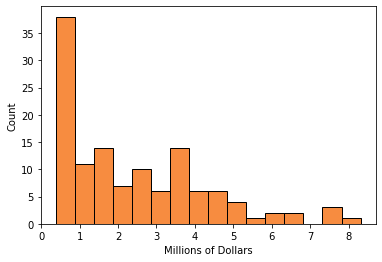

In [53]:
g1 = sns.histplot(data=master, x="SalaryInMil", bins = 16, color = '#F56600' )
g1 = plt.xlabel('Millions of Dollars')
plt.show(g1)

Sure enough, a large number of coaches in Division 1 are making less than 1 Million per year, while the coaches salaries continue to string out upwards to over 8 Million..  

Creating another feature converting Salaries to natural logs.  This can be useful in normalizing data and pulling in long tails/outlier data (which we clearly have).  I'm not sure if it'll be useful, but I'm creating it nonetheless.

In [54]:
master['LogSal'] = np.log(master['SchoolPay'])

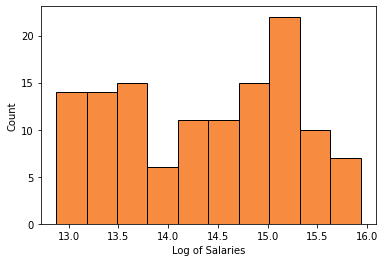

In [85]:
g8 = sns.histplot(data=master, x="LogSal", bins=10, color = '#F56600' )
g8 = plt.xlabel('Log of Salaries')
plt.show(g8)

The Log Salaries definitely have less of a tail.  Interestingly, the transformed salaries almost appear to be bimodal.  This will probably make it difficult to run a linear regression on

### Coach Data Exploration

Let's take a look at the coaches themselves.  Do their specific records have any bearing on how much they are paid?

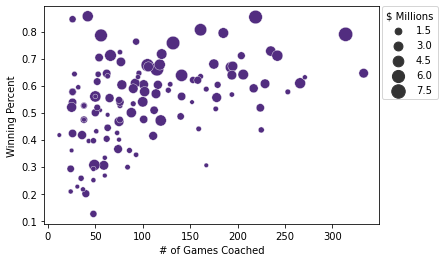

In [56]:
master['CoachPct'] = round(master['coachWins'] / master['coachGames'],3)
g2 = sns.scatterplot(data = master, x='coachGames', y='CoachPct', size='SalaryInMil', color= '#522D80', sizes = (20, 200))
g2 = plt.xlabel('# of Games Coached')
g2= plt.ylabel('Winning Percent')
g2=plt.legend(title = "$ Millions", bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.show(g2)

There certainly seems to be some amount of correlation between winning percentage and salary.  There might also be a slight bump for experience, but it seems less pronounced.

### Conference

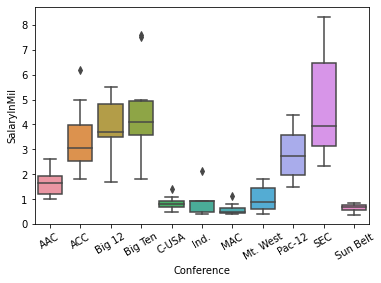

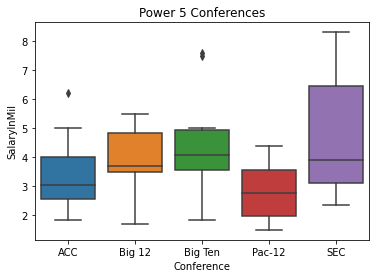

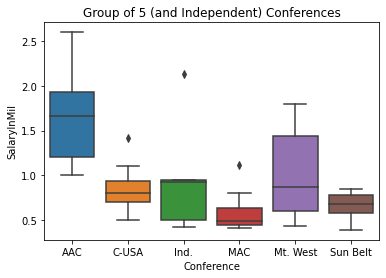

In [57]:
confOrder = master['Conference'].unique()
confOrder = sorted(confOrder)

g3 = sns.boxplot(data=master, y='SalaryInMil', x='Conference', order = confOrder)
g3 = plt.setp(g3.get_xticklabels(), rotation = 30)
plt.show(g3)


g4 = sns.boxplot(data=master, y='SalaryInMil', x='Conference', order = power5)
g4 = plt.title('Power 5 Conferences')
plt.show(g4)


g5 = sns.boxplot(data=master, y='SalaryInMil', x='Conference', order = group5)
g5 = plt.title('Group of 5 (and Independent) Conferences')
plt.show(g5)

Several things stand out when looking at the plots by conference.  1 - There are some haves and some have-nots.  Not surprisingly, the 5 conferences called the "Power 5" conferences hae much higher median salaries - coming in around the \$3-4 million mark for each.  Meanwhile the "Group of 5" conferences - oft derided as a lesser tier of competition - have median salaries around $1 million.  Though officially, any school has a chance at the playoffs, it's clear, based on recent Playoff Committee selections, that if you want to play (in the playoffs) you'd better pay (your coaches.  Not the players, that'd be silly).

### School Variables

In [58]:
schoolhist = ['SalaryInMil','Team Wins', 'Team Win Pct', 'Years', 'Team Total Games', 'Championships', 'Bowl Wins', 'Bowls Played', 'Bowl Win Pct', 'Capacity']
corr = master[schoolhist].corr()
display(corr)

,SalaryInMil,Team Wins,Team Win Pct,Years,Team Total Games,Championships,Bowl Wins,Bowls Played,Bowl Win Pct,Capacity
SalaryInMil,1.000000,0.640431,0.536251,0.415285,0.477478,0.544075,0.658476,0.693882,0.147636,0.823730
Team Wins,0.640431,1.000000,0.690403,0.852536,0.896648,0.511759,0.418521,0.463932,0.119110,0.592603
Team Win Pct,0.536251,0.690403,1.000000,0.262796,0.338351,0.606752,0.494219,0.500772,0.242955,0.558087
Years,0.415285,0.852536,0.262796,1.000000,0.986787,0.200403,0.112743,0.162707,-0.005634,0.319317
Team Total Games,0.477478,0.896648,0.338351,0.986787,1.000000,0.245970,0.190402,0.242822,0.032039,0.390874
Championships,0.544075,0.511759,0.606752,0.200403,0.245970,1.000000,0.544947,0.535349,0.118474,0.566899
Bowl Wins,0.658476,0.418521,0.494219,0.112743,0.190402,0.544947,1.000000,0.973062,0.332392,0.737252
Bowls Played,0.693882,0.463932,0.500772,0.162707,0.242822,0.535349,0.973062,1.000000,0.213537,0.774986
Bowl Win Pct,0.147636,0.119110,0.242955,-0.005634,0.032039,0.118474,0.332392,0.213537,1.000000,0.171479
Capacity,0.823730,0.592603,0.558087,0.319317,0.390874,0.566899,0.737252,0.774986,0.171479,1.000000


There are a lot of interesting correlations here.  It becomes clear that a team's history says a lot about what they pay for a coach.  A team with a vaunted history of winning is likely going to spend a lot for a coach that delivers the W's.  (A different discussion could be had here about how much these teams spend to get RID of said coach when they start racking up the L's..)

Looking over correlations, there is a good positive response with # of Wins in school history.  This is stronger than the schools Win Percent, their total games played, and number of years they've been around.  However, those variables are VERY strongly correlated with Team Wins, so we should probably stick to only Team Wins in order to avoid multicollinearity.

Similarly, there is a good response from the number of Bowls played - better than the number of Bowl Wins, or Bowl Winning Percent, which also have strong collinearity responses.  

I'm also intrigued by the somewhat positive response from number of championships in school history.  Though this has some collinearity with win histories, I think it's a valuable metric on its own.  The same goes for stadium capacity.

There is a strong correlation with salary and stadium capacity.  If you have a big stadium, you probably need a big-ticket coach.  There is some collinearity here with Bowl histories, but this variable also seems important on its own.

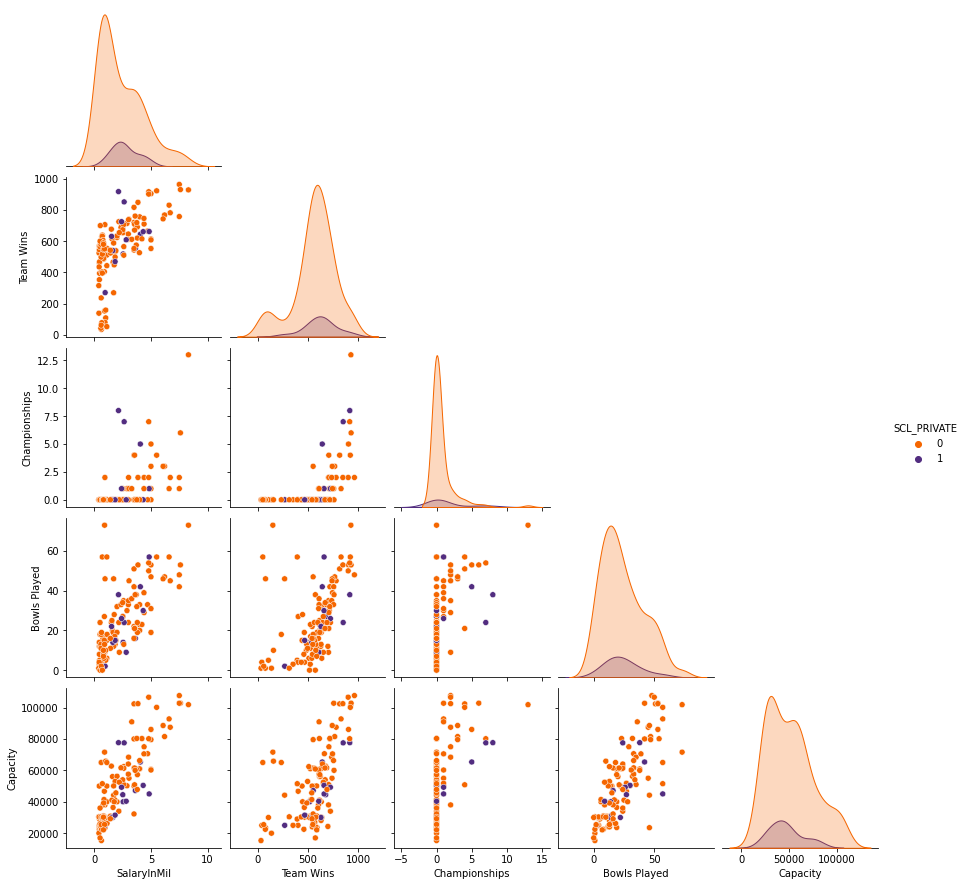

In [59]:
corlist = ['SalaryInMil', 'Team Wins', 'Championships', 'Bowls Played', 'Capacity', 'SCL_PRIVATE']
g6 = sns.pairplot(data = master[corlist], corner=True, hue = 'SCL_PRIVATE', palette= ['#F56600', '#522D80'])
plt.show(g6)

A graphical look at the correlations, but this time also broken out by Public vs. Private schools.  There appears to be no real difference based on where academic funding comes from.

### Graduation Rates

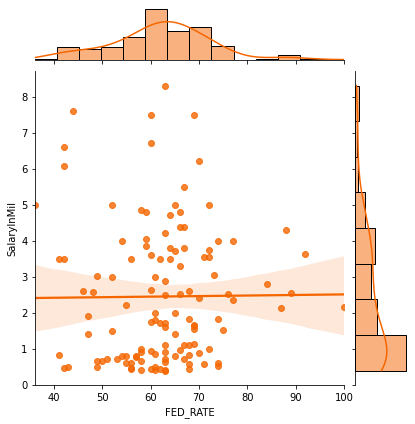

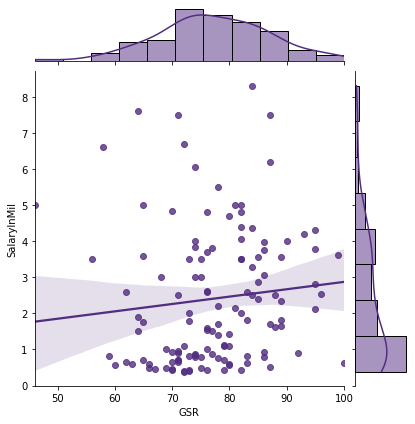

In [60]:
g7 = sns.jointplot(data= master, x = 'FED_RATE', y = 'SalaryInMil', color = '#F56600', kind="reg", )
plt.show(g7)

g8 = sns.jointplot(data= master, x = "GSR", y = "SalaryInMil", kind = "reg", color = '#522D80')
plt.show(g8)

The GSR seems to have a somewhat stronger relationship with salary than the Fed Rate.  This is interesting, but I wonder if this has to do with the fact that the GSR takes transfers into account.  More popular schools see a lot of transfers as athletes recruited with big promises get tired of seeing no playtime and move to smaller schools.  This would lower the Fed Rate numbers, but less so the GSR.

### Salary By State

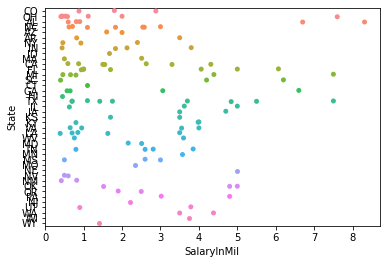

In [61]:
g9 = sns.stripplot(data=master, y = 'State', x='SalaryInMil')
plt.show(g9)

Nothing to see here, folks.  Possibly if this was converted into regional data, but there's only so much time.

### 2019 Season Record

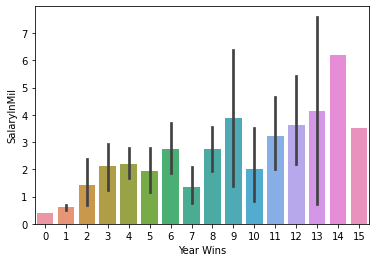

In [62]:
g10 = sns.barplot(data=master, x='Year Wins', y='SalaryInMil')
plt.show(g10)

Not a lot of data to go on here, and it's clear that teams with few wins pay less, but the data gets murkier when you get to to 9+ wins.  

## Model Creation

### Training and Testing Data

In [63]:
# Rename 2 variables to make it easier for modeling
master['BowlsPlayed'] = master['Bowls Played']
master['TeamWins'] = master['Team Wins']

In [64]:
# Need to create 2 sets of data - 1 to train and one for later testing.  

# With 125 variables, going to split 80/20 - with 100 training, and 25 reserved for testing.

#Using the Train/Test split feature from SKLearn to create 2 test dataframes
modelTrain, modelTest = train_test_split(master, test_size = 0.2, random_state = 17)

# Display heads and shape of each
display(modelTrain.shape)
display(modelTest.shape)

(100, 39)

(25, 39)

### Model Creation and Improvement

My first model will use features I believe have the most impact on salary.  That is: Conference, Capacity, # of Bowl Games Played, Championships, Coach Winning Percent, and Total Number of Team Wins.

In [65]:
lm1_str = 'SalaryInMil ~ Conference + Capacity + BowlsPlayed + Championships + CoachPct + TeamWins'
lm1 = smf.ols(lm1_str, data=modelTrain).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:            SalaryInMil   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     33.90
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           2.92e-29
Time:                        19:09:37   Log-Likelihood:                -106.00
No. Observations:                 100   AIC:                             244.0
Df Residuals:                      84   BIC:                             285.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0

So, a pretty decent model, maybe a little too overfit, but we'll see..  Some things I notice when I look at the variables, several of them don't seem to have much effect.  Looking at confidence intervals for the coefficients - Team Wins, Bowls Played, and several conferences all have intervals that include 0.  This means this variable potentially has 0 impact on salary, and thus ought to be ignored.  Interestingly, looking over the conferences, the only ones that seem to have an impact are the Power 5 group.  The rest ought to be removed.  

In [66]:
# For second model, I simplified the conference breakdown into Power 5/Group of 5 to see if that makes a difference
lm2_str = 'SalaryInMil ~ Group + Capacity + Championships + CoachPct'
lm2 = smf.ols(lm2_str, data=modelTrain).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:            SalaryInMil   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     65.17
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           2.38e-34
Time:                        19:09:37   Log-Likelihood:                -108.35
No. Observations:                 100   AIC:                             234.7
Df Residuals:                      91   BIC:                             258.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.9201      0.303  

This model looks pretty good, based on the confidence intervals on the intercepts!  Plus, our adjusted R2 didn't change much - still around 83.8%.  Again, this might be due to overfit, but we'll see when we look at the Testing data.

### Model Testing

Testing of Model 1:

In [67]:
modelTest["mod1pred"] = round(lm1.predict(modelTest),2)
modelTest["mod1error"] = modelTest['SalaryInMil'] - modelTest['mod1pred']
stdError = round(np.power(modelTest['SalaryInMil'].corr(modelTest['mod1pred']),2),3)
print("The total accounted for Variance by Model 1 for the Test Set was: ", stdError)

modelTest["mod2pred"] = round(lm2.predict(modelTest),2)
modelTest["mod2error"] = modelTest['SalaryInMil'] - modelTest['mod2pred']
stdError = round(np.power(modelTest['SalaryInMil'].corr(modelTest['mod2pred']),2),3)
print("The total accounted for Variance by Model 2 for the Test Set was: ", stdError)

The total accounted for Variance by Model 1 for the Test Set was:  0.778
The total accounted for Variance by Model 2 for the Test Set was:  0.771


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Both models had similar results against the Test data, accounting for 77-78% of the variance in the data.  That's pretty good for first passes!  My suspicion is that some data - like championship data - is more significant based on recent history.  IE - if I had pulled championships in the last 2 decades, I wonder how the results might change.

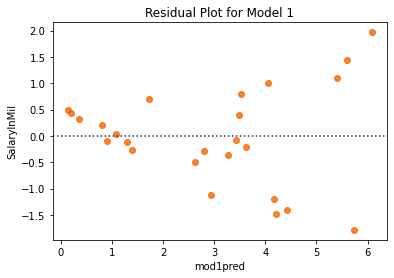

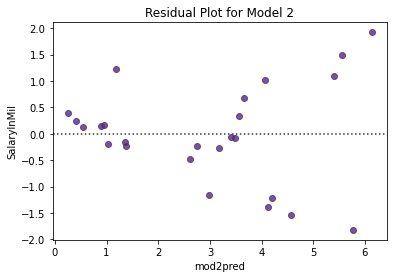

In [87]:
m1 = sns.residplot(data=modelTest, x='mod1pred', y='SalaryInMil', color = '#F56600')
m1 = m1.set_title("Residual Plot for Model 1")
plt.show(m1)

m2 = sns.residplot(data=modelTest, x='mod2pred', y='SalaryInMil', color = '#522D80')
m2 = m2.set_title("Residual Plot for Model 2")
plt.show(m2)

Looking at residuals for both plots, I see no general trends that might signal in issue with collinearity.  What I do note, however, is heteroscedacticity -  the variance grows very wide as the predicted salaries increase.  I suspect this is because of the large range of salary values for coaches.  I am curious how Model 2 does when used to predict the natural log of salaries.   

In [69]:
# Linear Model 3 - the same as LM2, but used to predict LogSal instead of SalInMillions
lm3_str = 'LogSal ~ Group + Capacity + Championships + CoachPct'
lm3 = smf.ols(lm3_str, data=modelTrain).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:                 LogSal   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     65.33
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           2.15e-34
Time:                        19:09:38   Log-Likelihood:                -31.239
No. Observations:                 100   AIC:                             80.48
Df Residuals:                      91   BIC:                             103.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.7674      0.140  

The total accounted for Variance by Model 3 for the Test Set was:  0.882


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


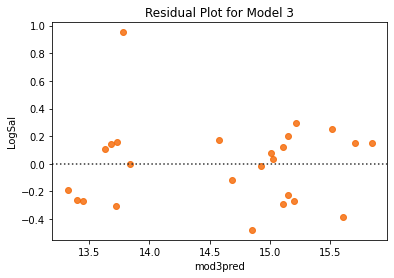

In [88]:
modelTest["mod3pred"] = round(lm3.predict(modelTest),2)
modelTest["mod3error"] = modelTest['LogSal'] - modelTest['mod3pred']
stdError = round(np.power(modelTest['LogSal'].corr(modelTest['mod3pred']),2),3)
print("The total accounted for Variance by Model 3 for the Test Set was: ", stdError)

m3 = sns.residplot(data=modelTest, x='mod3pred', y='LogSal', color = '#F56600')
m3 = m3.set_title("Residual Plot for Model 3")
plt.show(m3)

Look at that!  Total accounted variance of 88%!  And sure enough, the residual plot looks much better than the ones with standard data.  I think there are certainly ways one could improve upon it, but for our sakes, I think Model 3 is our winner!

Let's expand the model to all of the coaches and do a quick exploration of who it says is overpaid, and who is underpaid..

In [72]:
master['lmpred'] = lm3.predict(master)
stdError = round(np.power(master['LogSal'].corr(master['lmpred']),2),3)
print("The total accounted for Variance by Model 3 for the Test Set was: ", stdError)

master['Diff'] = master['LogSal'] - master['lmpred']
master['DiffDollars'] = round(master['SchoolPay'] - np.exp(master['lmpred']),0)

vars = ['School', 'Coach', 'SchoolPay', 'LogSal', 'lmpred', 'Diff', 'DiffDollars']
underpaid = master[vars].sort_values('DiffDollars')
display(underpaid.head(5))

overpaid = master[vars].sort_values('DiffDollars', ascending = False)
display(overpaid.head(5))

The total accounted for Variance by Model 3 for the Test Set was:  0.854


,School,Coach,SchoolPay,LogSal,lmpred,Diff,DiffDollars
55,LSU,Ed Orgeron,3500000,15.068274,15.607799,-0.539525,-2503174.0
83,Oklahoma,Lincoln Riley,4800000,15.384126,15.683159,-0.299033,-1673059.0
103,Tennessee,Jeremy Pruitt,3846000,15.162544,15.473787,-0.311243,-1404255.0
5,Arizona,Kevin Sumlin,1600000,14.285514,14.908314,-0.622799,-1382623.0
98,Southern California,Clay Helton,2625965,14.780959,15.199699,-0.418740,-1365618.0


,School,Coach,SchoolPay,LogSal,lmpred,Diff,DiffDollars
42,Illinois,Lovie Smith,5000000,15.424948,14.776641,0.648307,2385348.0
62,Michigan,Jim Harbaugh,7504000,15.830947,15.597823,0.233124,1560416.0
34,Florida State,Willie Taggart,5000000,15.424948,15.085610,0.339338,1438793.0
59,Memphis,Mike Norvell,2600000,14.771022,14.103476,0.667546,1266289.0
69,Navy,Ken Niumatalolo,2163000,14.587007,13.781569,0.805437,1196372.0


You know, I might agree for several of these underpaid coaches.  Ed Orgeron will win the National Championship the year following this data..  Clay Helton IS underpaid at USC, but I suspect his stock is still rising.  Kevin Sumlin is an interesting find here though, but I guess the millions he's getting from Texas A&M to NOT coach isn't showing up here...

On the other hand, the overpaid list is, well, not much of a surprise.  The top 3 coaches have all been fired, and number 4 is actually at number 3 on this list, making a more reasonable salary than what they paid Willie Taggart for the same 'privelege'...  On the other hand, the data suggest Navy is overpaying for their coaching services, but any coach who beats Notre Dame 3 times in the last decade is worth the pay in my uneditorialized opinion...

### Recommended Salary for Syracuse

The first question to answer - according to the model, how much should we be paying Dino Babers to coach at Syracuse?

In [73]:
key =lm3.get_prediction(master.loc[master['School']=="Syracuse"])
predint = key.summary_frame()

predint['Salary'] = round(np.exp(predint['mean']),0)
predint['LB'] = round(np.exp(predint['mean_ci_lower']),0)
predint['UB'] = round(np.exp(predint['mean_ci_upper']),0)

print("Predicted Salary:" , predint.loc[0]['Salary'])
print("Predicted Salary Range:" , predint.loc[0]['LB'] , "-", predint.loc[0]['UB'])
print("Actual 'Current' Salary:", master.loc[master['School'] == "Syracuse"]['SchoolPay'].values[0])
#display(round(np.exp(14.656),0))
#display(round(np.exp(15.155),0))

#key2 =lm2.get_prediction(master.loc[master['School']=="Navy"])
#display(key2.summary_frame())

#display(master.loc[master['School']=="Syracuse"])

Predicted Salary: 2973730.0
Predicted Salary Range: 2317053.0 - 3816516.0
Actual 'Current' Salary: 2401206


### Big East Model

What might salaries look like if the Big East were still a thing?  For this, I recreated the linear model from LM3, but in place of conference, i used a realignment called BigEastDream - where the original Big East teams are pulled back together.

In [74]:
# Linear Model 4 - the Big East one
lm4_str = 'LogSal ~ BigEastDream + Capacity + Championships + CoachPct'
lm4 = smf.ols(lm4_str, data=modelTrain).fit()
print(lm4.summary())

                            OLS Regression Results                            
Dep. Variable:                 LogSal   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     51.23
Date:                Sat, 30 Jan 2021   Prob (F-statistic):           2.52e-35
Time:                        19:09:38   Log-Likelihood:                -14.435
No. Observations:                 100   AIC:                             58.87
Df Residuals:                      85   BIC:                             97.95
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [75]:
key =lm4.get_prediction(master.loc[master['School']=="Syracuse"])
predint = key.summary_frame()

predint['Salary'] = round(np.exp(predint['mean']),0)
predint['LB'] = round(np.exp(predint['mean_ci_lower']),0)
predint['UB'] = round(np.exp(predint['mean_ci_upper']),0)

print("Predicted Salary if still in the Big East:" , predint.loc[0]['Salary'])
print("Predicted Salary Range if still in the Big East:" , predint.loc[0]['LB'] , "-", predint.loc[0]['UB'])
print("Actual 'Current' Salary:", master.loc[master['School'] == "Syracuse"]['SchoolPay'].values[0])

Predicted Salary if still in the Big East: 1725253.0
Predicted Salary Range if still in the Big East: 1315754.0 - 2262199.0
Actual 'Current' Salary: 2401206


So Syracuse could have saved like, half a million dollars on a head coach if they'd NOT joined the ACC..  But what would have happened if they joined the Big 10 instead..?

### Big 10 Syracuse

In [76]:
bigTenCuse = master[master['School'] == "Syracuse"]
bigTenCuse['Group'] = 'Big Ten'

key =lm3.get_prediction(bigTenCuse)
predint = key.summary_frame()

predint['Salary'] = round(np.exp(predint['mean']),0)
predint['LB'] = round(np.exp(predint['mean_ci_lower']),0)
predint['UB'] = round(np.exp(predint['mean_ci_upper']),0)

print("Predicted Salary if in the Big Ten:" , predint.loc[0]['Salary'])
print("Predicted Salary Range if in the Big Ten:" , predint.loc[0]['LB'] , "-", predint.loc[0]['UB'])
print("Actual 'Current' Salary:", master.loc[master['School'] == "Syracuse"]['SchoolPay'].values[0])

Predicted Salary if in the Big Ten: 3216030.0
Predicted Salary Range if in the Big Ten: 2555543.0 - 4047222.0
Actual 'Current' Salary: 2401206


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


So, if Syracuse had joined the Big Ten, the model predicts the Orange would have to pay their coach more than 300k than it predicts it should pay for them to be in the ACC - almost 1 Million dollars more than their current salary.  Leaders and Legends indeed..